In [17]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials                                                               
                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  

comp_tdist

In [18]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [58]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 2

# training
x1 = [0., .5, .8, 1., 1.6, 2.]
x2 = [0., .8, 1., 1.6, 2.]

# testing
x01 = .25
x02 = .4

# underlying 1d function 
test_fun1(x) = sin(x) + 1.1


test_fun1 (generic function with 1 method)

# Summary
Settings parameters: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data

Tests:
1. p=1 or p=2, x=x1, x0=x01 \
    pdf very sharp and narrow, it's a hard case for quantile computation

Generally 1d prediction works well, could predict very high probabily around the true value, which can be a hard case for quantile computation

In [59]:
p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x2 # choose training data 
x0 = x02 # choose testing data
test_fun = test_fun1 # choose underlying function

x = reshape(x, size(x, 1), 1)
x0 = reshape([x0], 1, 1) 
Fx = covariate_fun(x, p)
y = reshape(test_fun.(x), size(x, 1))
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = reshape(test_fun.(x0), 1)./ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")

Prediction at x0 = [0.4]
Covariates at x0: [1.0]
Should expect peak near [0.7093908687702278]


In [63]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 100]
rangeλ = [0.5 5]

btg1 = btg(trainingData1, rangeθ, rangeλ)
(dpdf, pdf, cdf) = solve(btg1)
dpdf_fixed = y0 -> dpdf(x0, Fx0, y0) 
pdf_fixed = y0 -> pdf(x0, Fx0, y0)
cdf_fixed = y0 -> cdf(x0, Fx0, y0)

Iterating over nodeset to build train_buffer_dict...
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12


#245 (generic function with 1 method)

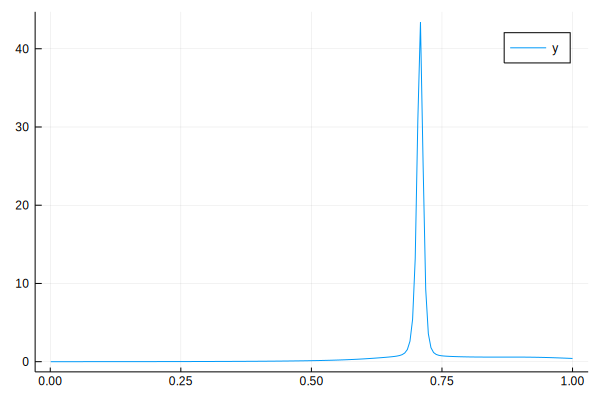

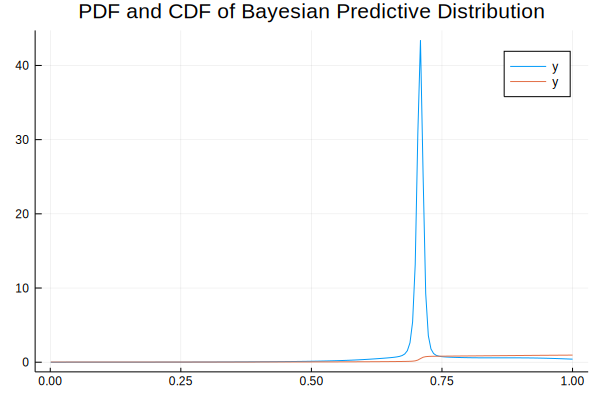

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.022780870083823467, 0.02278559509928975, 0.022790722894465175, 0.02279641690664717, 0.02280270895069443, 0.02280961983230473, 0.022817169709267945, 0.02282538002178403, 0.022834273891912386, 0.02284387616579283  …  0.936432391769591, 0.9390420366007349, 0.9415986076866368, 0.9440986236223181, 0.9465388332695087, 0.9489162526618233, 0.9512281975309084, 0.9534723107174702, 0.955646583877405, 0.957749373068563])

In [62]:
a = 1e-3; b = 1
plt(pdf_fixed, a, b, 200)
plt!(cdf_fixed, a, b, 200, title = "PDF and CDF of Bayesian Predictive Distribution")